### Using Sopra and Balmer gamma, we want to do some synthetic spectroscopy
- get rid of bugs
- understand effects like smearing, weighting the fit, excluding areas

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib

from divertor_spectroscopy import analysis
from divertor_spectroscopy import utilities as utils
from divertor_spectroscopy import instrument

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + colors[1:]
save_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/Reports/thesis/Weekly_meetings/05_radiation_dynamics/"

In [86]:
Te_array = np.arange(1,15)
ne_array = np.linspace(0.5e19,20e19,40)

{'exclude_wavelength_from_fit': None, 'zeeman': False, 'magnetic_field': 0, 'angle_to_magnetic_field': 90, 'multiplets': {}, 'balmer_lines': {'H_gamma': 1.0}}


\\share.ipp-hgw.mpg.de\documents\frhe\documents\phd\git\divertor_spectroscopy\divertor_spectroscopy\analysis.py:382: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.sqrt(ydata))


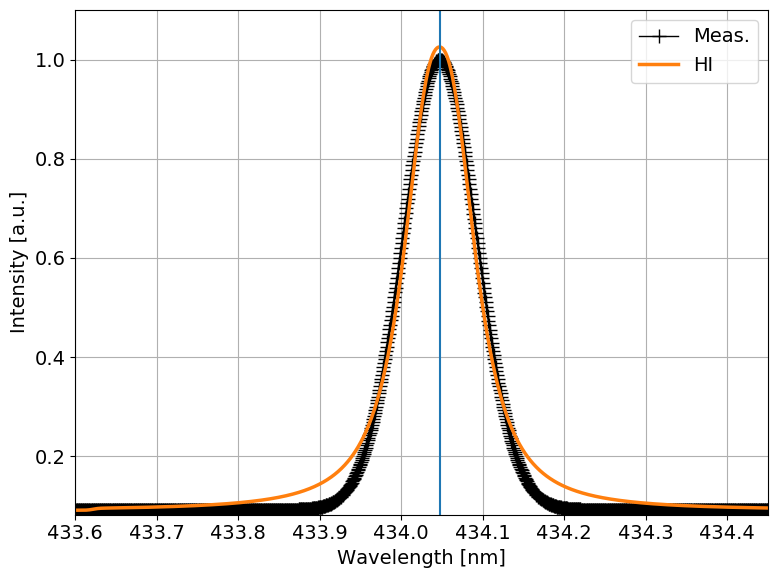

fit_description  fit_parameters  fit_parameters_linear      guess  \
0      Intensity_H_gamma       -0.937009           1.156087e-01  -2.143004   
1  Stark_density_H_gamma       20.415345           2.602225e+20  18.698970   

   lower_bounds  upper_bounds  
0     -2.671302     -0.101583  
1     18.000000     21.000000

In [87]:
importlib.reload(analysis)
from divertor_spectroscopy.spectrum_models import sopraberlin_cw_434
stark_density = True
model = sopraberlin_cw_434.Sopraberlin_cw_434(zeeman=False,stark_density=stark_density)
if stark_density:
    model.balmer_lines[0].doppler_temperature = 10
    model.balmer_lines[0].electron_density = 5e18
else:
    model.multiplets[0].fit_broadening = True

wavelength = np.linspace(433.6,434.45,1024)
instrument_function_mode = "convolution_entire_spectrum"
instrument_function_mode = "gauss"
width = 3.8*np.abs(wavelength[1]-wavelength[0])
inst = instrument.Instrument(wavelength=wavelength,instrument_function_mode=instrument_function_mode,width=width,numeric_instrument_function=True)

analyse = analysis.Analysis(model=model,instrument=inst)
analyse.get_default_fit_parameters()
analyse.default_fit_parameters
print(model.all_model_parameters)
experiment_data = analyse.build_spectrum(wavelength,*analyse.default_fit_parameters)#+np.random.rand(1024)*1e16 
experiment_data = experiment_data/np.max(experiment_data)+0.1
if stark_density:
    model.balmer_lines[0].doppler_temperature = 0.1
else:
    model.multiplets[0].doppler_temperature = 0.1
experiment_data = experiment_data/np.max(experiment_data)

wavelength_to_fit = [433.8,434.3]
wavelength_to_fit = None
exclude_wavelength_from_fit = model.exclude_wavelength_from_fit
exclude_wavelength_from_fit = [[433.65,433.8],[434.2,434.6]]
exclude_wavelength_from_fit = None
analyse.fit_spectrum(experiment_data=experiment_data,wavelength_to_fit=wavelength_to_fit,exclude_wavelength_from_fit=exclude_wavelength_from_fit)
add_spectra = []# adding the numeric instrument function
analyse.display_spectrum(scale="linear",highlight_tags=["HI"],experiment=True,show_positions=True,background_guess=False,guess=False,fit=False,add_spectra=add_spectra)
analyse.format_fit_output()
df_fit_parameters = {}
for i,fit_parameter in enumerate(analyse.fit_description):
    df_fit_parameters[fit_parameter] = analyse.fit_parameters_linear[i]
analyse.fit_output

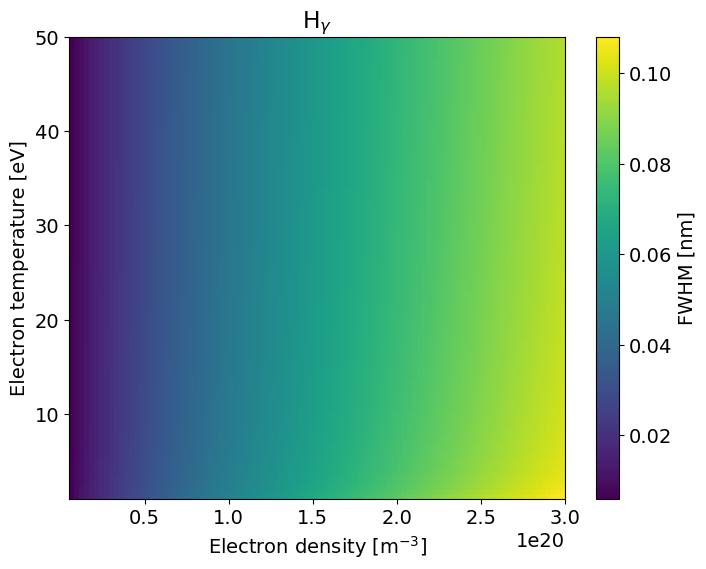

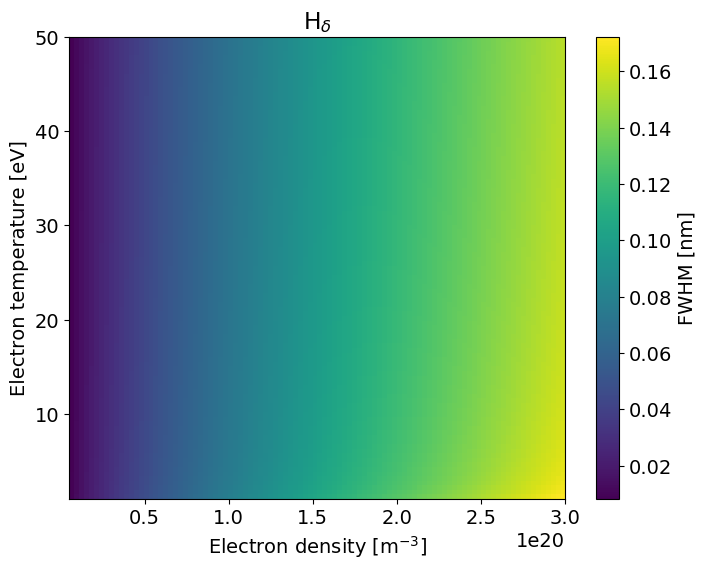

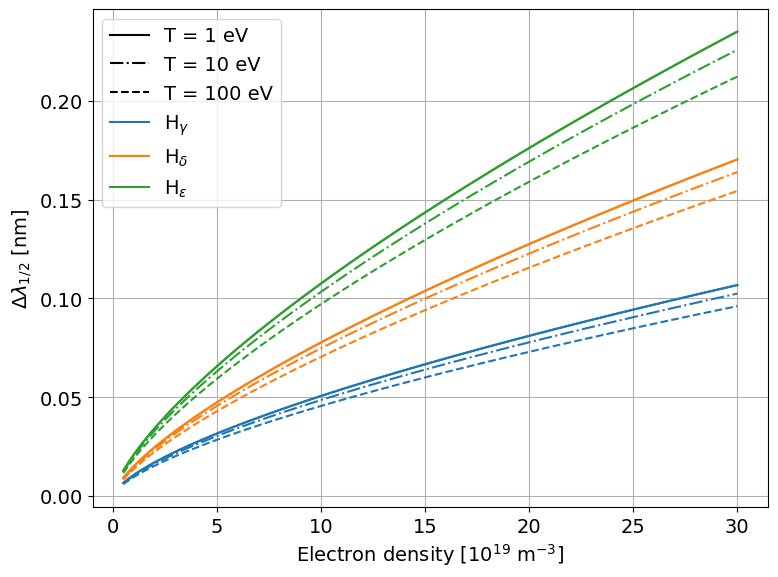

In [88]:
from divertor_spectroscopy import atomic_data
from divertor_spectroscopy import spectral_line_classes

line = spectral_line_classes.Balmer_lines(lines=["H_gamma","H_delta","H_epsilon"])
line.get_fwhm(1e20,1)

ne_array = np.linspace(5e18,0.3e21,100)
Te_array = np.linspace(1,50,101)
fwhm_gamma = np.zeros((len(ne_array),len(Te_array)))
fwhm_delta = np.zeros((len(ne_array),len(Te_array)))
fwhm_epsilon = np.zeros((len(ne_array),len(Te_array)))
for n_idx,n in enumerate(ne_array):
    for T_idx,T in enumerate(Te_array):
        fwhm_gamma[n_idx,T_idx],fwhm_delta[n_idx,T_idx],fwhm_epsilon[n_idx,T_idx] = line.get_fwhm(n,T)
plt.figure(figsize=(8,6))
plt.title("H$_\gamma$")
extent = [ne_array[0],ne_array[-1],Te_array[0],Te_array[-1]]
plt.imshow(fwhm_gamma.T,aspect="auto",origin="lower",interpolation="none",extent=extent)
cbar = plt.colorbar()
cbar.set_label("FWHM [nm]")
plt.xlabel("Electron density [m$^{-3}$]")
plt.ylabel("Electron temperature [eV]")
plt.show()

plt.figure(figsize=(8,6))
plt.title("H$_\delta$")
extent = [ne_array[0],ne_array[-1],Te_array[0],Te_array[-1]]
plt.imshow(fwhm_delta.T,aspect="auto",origin="lower",interpolation="none",extent=extent)
cbar = plt.colorbar()
cbar.set_label("FWHM [nm]")
plt.xlabel("Electron density [m$^{-3}$]")
plt.ylabel("Electron temperature [eV]")
plt.show()

import matplotlib.pyplot as plt

temperatures_to_display = [1, 10, 100]
shapes = ["-", "-.", "--"]
colors = ["C0", "C1", "C2"]  # Example colors

plt.figure(figsize=(8,6))

# Define labels for spectral lines once
line_labels = ["H$_\gamma$", "H$_\delta$", "H$_\epsilon$"]

for t_idx, temperature_to_display in enumerate(temperatures_to_display):
    plt.plot([], [], label=f"T = {temperature_to_display} eV", ls=shapes[t_idx], color="black")  # Temperature legend

for line_idx, (fwhm_data, label) in enumerate(zip(
        [fwhm_gamma, fwhm_delta, fwhm_epsilon], line_labels)):
    plt.plot(ne_array/1e19, fwhm_data[:, temperatures_to_display[0]], label=label, color=colors[line_idx])  # One label per line
    
    for t_idx, temperature_to_display in enumerate(temperatures_to_display):
        plt.plot(ne_array/1e19, fwhm_data[:, temperature_to_display], color=colors[line_idx], ls=shapes[t_idx])

plt.ylabel("$\Delta\lambda_{1/2}$ [nm]")
plt.xlabel("Electron density [10$^{19}$ m$^{-3}$]")
plt.legend()
plt.grid()
plt.tight_layout()
save_title = "Stark_FWHM_vs_ne_Te"
plt.savefig(save_path+save_title+".pdf")
plt.savefig(save_path+save_title+".png",dpi=400)
plt.show()


### I want to compare purely Doppler broadening to Stark broadening

In [89]:
densities = np.linspace(1e19,2e20,11)
print(densities)
plt.figure(figsize=(8,6))

plt.show()

[1.00e+19 2.90e+19 4.80e+19 6.70e+19 8.60e+19 1.05e+20 1.24e+20 1.43e+20
 1.62e+20 1.81e+20 2.00e+20]


<Figure size 800x600 with 0 Axes>

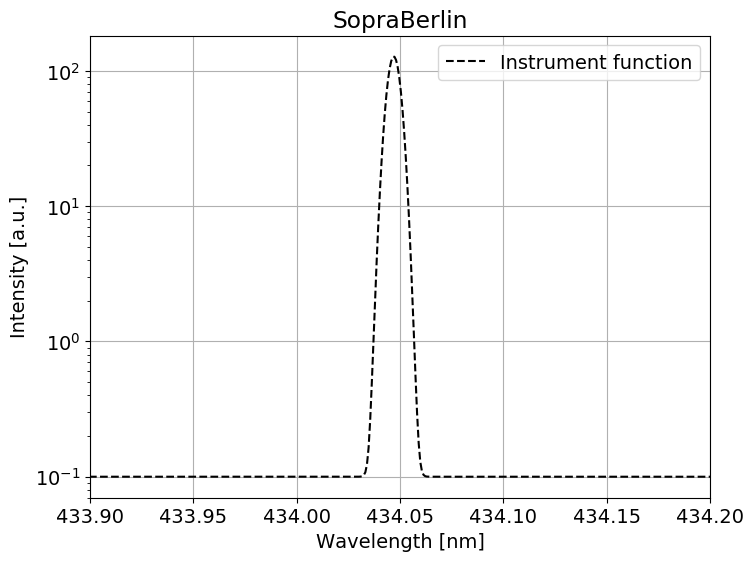

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors



# Define parameter ranges
densities = np.linspace(1e19, 2e20, num=5)  # Electron densities
temperatures = np.linspace(1, 10, num=5)    # Electron temperatures

# Setup wavelength
wavelength = np.linspace(433.6, 434.4, 1024)
lambda_0 = 434.047

# Initialize the spectral line
line = spectral_line_classes.Balmer_lines(lines=["H_gamma"])

# Set up colormaps
colormap_gauss = cm.coolwarm  # For temperature variation
colormap_lorentz = cm.coolwarm  # For density variation
norm_temp = mcolors.Normalize(vmin=min(temperatures), vmax=max(temperatures))
norm_density = mcolors.Normalize(vmin=min(densities), vmax=max(densities))

# Assign colors for plotting
colors_gauss = [colormap_gauss(norm_temp(T)) for T in temperatures]
colors_lorentz = [colormap_lorentz(norm_density(n)) for n in densities]

plt.figure(figsize=(8,6))


if True:
    # Plot Lorentzian-broadened lines (Lomanowski model)
    for idx, density in enumerate(densities):
        fwhm = line.get_fwhm(ne=density, Te=3)
        y_lomanowski = utils.lomanowski(wavelength, position=lambda_0, fwhm=fwhm[0])
        plt.plot(wavelength+0.1, y_lomanowski+0.1, color=colors_lorentz[idx],label="Lorentz {} m$^{{-3}}$".format(density))  # Hide from auto-legend

    # Plot Gaussian-broadened lines (Doppler effect)
    for idx, temp in enumerate(temperatures):
        doppler_width = utils.doppler_broadening_nist(T=temp, m=1, lambda_0=lambda_0)
        y_doppler = utils.gauss(wavelength, position=lambda_0, width=doppler_width)
        plt.plot(wavelength-0.1, y_doppler+0.1, color=colors_gauss[idx], ls="--",label="Gauss {} eV".format(temp))  # Hide from auto-legend


else:
    width_instrument = 4 * np.abs(wavelength[1] - wavelength[0])
    y_instrument = utils.gauss(wavelength, position=lambda_0, width=width_instrument)
    # Plot the instrument function as reference
    plt.plot(wavelength, y_instrument+0.1, label="Instrument function", color="black", linestyle="dashed")
plt.legend()
plt.grid()
plt.title("SopraBerlin")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [a.u.]")
plt.yscale("log")
plt.xlim(433.9,434.2)
plt.show()


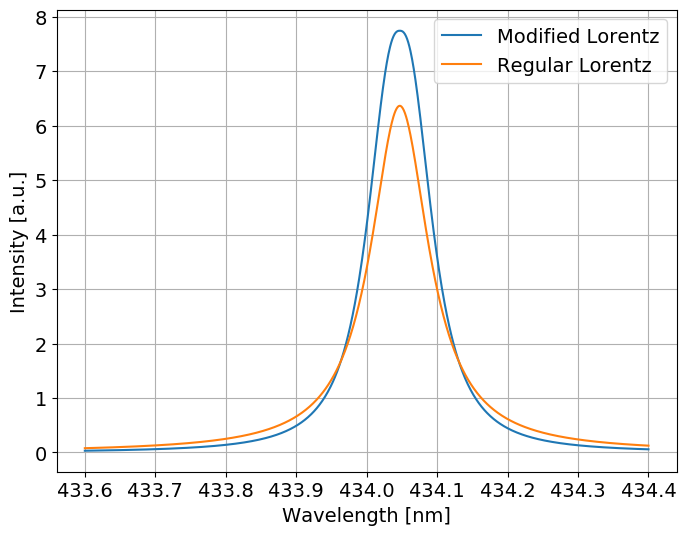

In [115]:
plt.figure(figsize=(8,6))
plt.plot(wavelength,utils.lomanowski(wavelength,position=lambda_0,fwhm=0.1),label="Modified Lorentz")
plt.plot(wavelength,utils.lorentz(wavelength,position=lambda_0,fwhm=0.1),label="Regular Lorentz")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [a.u.]")
plt.legend()
plt.grid()
plt.show()